# Processing spectra
In the previous section, we looked at different ways of reading in data and introduced the `ProjectMSI` class. Now we want to process the spectra. We will cover the following steps:
* adding up spectra
* estimating the baseline
* lock-mass calibration
* peak-finding
* binning
* filtering
* creating a feature table
Furthermore, we will look at a method to combine multiple measurements with the same mass window.

Again, we will first investigate the more comprehensive, less elegant approach and afterward, the one using the `ProjectMSI` class.

One of the big challenges that we face for MALDI data specifically is that we have multiple spectra, which are prone to noise. This means that peaks belonging to the same molecule are shifted by a few mDa from spectrum to spectrum. This makes data reduction more challenging since we want to end up with a data cube where each plane corresponds to the ion image of a compound.

## Motivation
Previously, this was tackled by using the line or centroid spectra and performing kernel density estimation on the distribution of masses over all spectra (see https://github.com/weimin-liu/msi_feature_extraction). In this workflow we rely on the profile spectra: firstly, the profile spectra are resampled such that each spectrum contains intensity values at the same masses. A convenient choice is an even sampling, as introduced in the previous section. Notice that it is not possible to add spectra without interpolation because the spectra in the mcf files are sampled at different locations for each spectrum.

One advantage of combining profile spectra before peak picking is that high-frequency noise flattens out and is less likely to be detected as peaks. Furthermore, being able to access the profile spectra is advantageous for calibrations or anything that involves comparing spectra. Conventionally, one would use the line spectra (position of peaks and widths of peaks) to reconstruct the original spectrum. Maintaining the profile spectra on the other hand does not run the risk of biases due to false peaks or inaccurate peak shape estimation. 

Instead of finding the peaks within each spectrum, peaks are estimated from the summed-up spectrum, which we call *kernels* (each kernel represents one compound), and then those kernels are used to estimate the intensities of compounds.

## Step-by-step
With that out of the way, let's take a look at each step. We will also compare the targeted and untargeted approaches, the targeted approach allows a reduction of the number of peaks and is less sensitive to the peak-picking method. 

### Setting up
First of all, we need a reader (either `ReadBrukerMCF` or `hdf5Handler`) and a `Spectra` instance, in this example we will go with the `hdf5Handler` version. If you skipped the previous section and did not create an hdf5 file you can replace the code in the cell below by
```python
reader = ReadBrukerMCF(path_d_folder)
reader.create_reader()
reader.create_indices()
reader.set_meta_data()
reader.set_QTOF_window()
```

In [1]:
from msi_workflow import Spectra, ReadBrukerMCF, hdf5Handler

In [2]:
# define the path to the .d folder
path_d_folder = r'C:\Users\Yannick Zander\Promotion\Test data\13012023_SBB_TG3A_05-10_Test2.d'

In [3]:
# initiate the reader
reader = hdf5Handler(path_d_folder)

Now let's instanciate the `Spectra` object

In [4]:
spec = Spectra(reader=reader)

The first step is always to add up all spectra (they will be resampled automatically). This method loops over all spectra, which requires reading them all in. This is where the hdf5 file would pay off, but for this toy-example this is not a big concern

In [5]:
spec.add_all_spectra(reader=reader)

Adding spectra: 100%|█████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 368.34it/s]


But in case you followed the pervious section, here is a quick speed comparison (not including initialization of the readers):

In [6]:
from msi_workflow import Spectra, ReadBrukerMCF, hdf5Handler
import os
import time

path_d_folder = r'C:\Users\Yannick Zander\Promotion\Test data\13012023_SBB_TG3A_05-10_Test2.d'

mcf = ReadBrukerMCF(path_d_folder)
mcf.create_reader()
mcf.create_indices()
mcf.set_meta_data()
mcf.set_QTOF_window()

hdf = hdf5Handler(os.path.join(path_d_folder, 'Spectra.hdf5'))

test = Spectra(reader=mcf)
mcf_start = time.time()
test.add_all_spectra(mcf)
mcf_end = time.time()

test = Spectra(reader=hdf)
hdf_start = time.time()
test.add_all_spectra(hdf)
hdf_end = time.time()

print(f'Adding up with ReadBrukerMCF took {mcf_end - mcf_start:.1f} seconds')
print(f'Adding up with hdf5Handler took {hdf_end - hdf_start:.1f} seconds')
print(f'resulting in a speedup-factor of {(mcf_end - mcf_start) / (hdf_end - hdf_start):.0f}')

Adding spectra: 100%|█████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 368.52it/s]

Adding up with ReadBrukerMCF took 4.7 seconds
Adding up with hdf5Handler took 0.2 seconds
resulting in a speedup-factor of 24


On my machine there is a speed-up by a factor of about 20. Anyway, let's move on. You can take a look at the summed up spectrum:

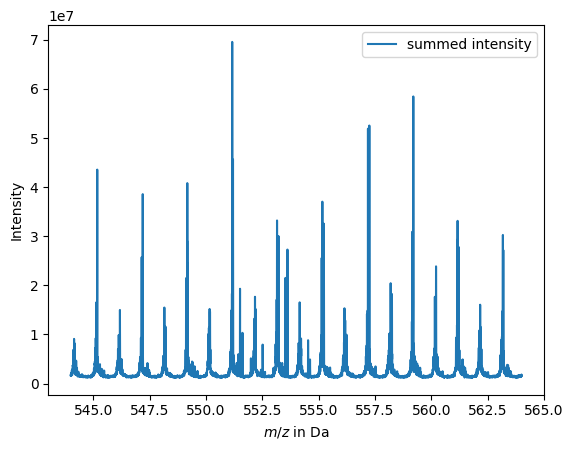

In [7]:
spec.plot_summed()

### Estimating the baseline level
Usually, a substantial baseline is noticeable between peaks. Especially for the kernel estimation, this is annoying. In this pipeline, a minimum filter is used to estimate the baseline level of the summed-up spectrum and afterward removed from the summed spectrum. Within the single spectra, the baseline divided by the number of spectra is used as the noise level.

In [8]:
spec.subtract_baseline()

In [9]:
spec._noise_level

array([21339.46282476, 21339.46282476, 21339.46282476, ...,
       18221.0665761 , 18221.0665761 , 18221.0665761 ])

The window size of the minimum filter is crucial. Usually, the automatic window-size determination does a good job, but if the window is too small, the baseline creeps into the peaks and we lose the peak shape, so be on the lookout for peaks that look like they collapsed. We can force this by making the window size too small:

Adding spectra: 100%|█████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 372.77it/s]


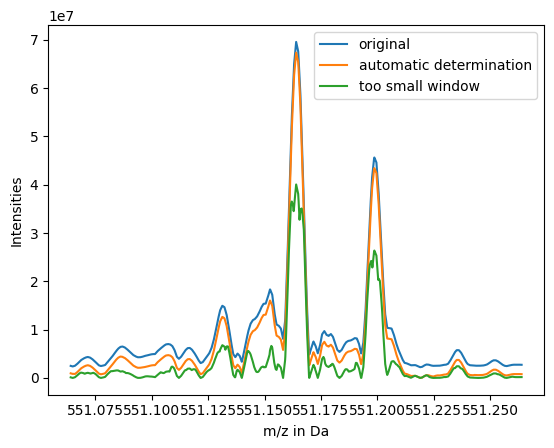

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# window around the largest peak
window_size = .1
center_mz = spec.mzs[np.argmax(spec.intensities)]

mask = (spec.mzs > center_mz - window_size) & (spec.mzs < center_mz + window_size)

spec.add_all_spectra(reader=reader)
plt.plot(spec.mzs[mask], spec.intensities[mask], label='original')

spec.add_all_spectra(reader=reader)
spec.subtract_baseline(overwrite=True)  # window size of .05 Da
plt.plot(spec.mzs[mask], spec.intensities[mask], label='automatic determination')

spec.add_all_spectra(reader=reader)
spec.subtract_baseline(window_size=round(.005 / 1e-4))  # window size of 5 mDa
plt.plot(spec.mzs[mask], spec.intensities[mask], label='too small window')
plt.legend()
plt.xlabel('m/z in Da')
plt.ylabel('Intensities')
plt.show()

The automatic window-size estimation determines the biggest peak width at a relative height of 80%. 

In [11]:
# make sure we got a reasonable baseline in the end
spec.add_all_spectra(reader=reader)
spec.subtract_baseline()

Adding spectra: 100%|█████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 365.97it/s]


### Lock-mass calibration
The next step is to make sure that the spectra are aligned. This is achieved by looking for certain calibration masses within each spectrum. Each calibration mass is matched to a peak if it is close and high enough. From the differences, a polynomial is estimated that minimizes the differences between calibration masses and peaks. By default, the compound list suggested by Wörmer et al. (2019, https://doi.org/10.1016/j.orggeochem.2018.11.009) is used. We suggest using a low-degree polynomial because for higher-degree polynomials the correction can become quite large outside the mass range spanned by the calibrant masses. Furthermore, we suggest using a fairly high signal-to-noise ratio (SNR) threshold (by default 4) to make sure that calibrants are not matched to noise peaks. The default search range is 5 mDa.

Found calibration file. This suggests that Lock Mass calibration has been performed already.
Finding calibration parameters: 100%|█████████████████████████████████████████████████| 72/72 [00:00<00:00, 316.60it/s]


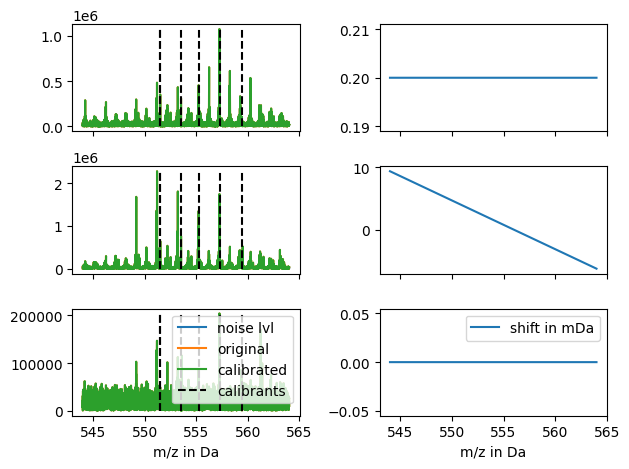

In [12]:
spec.require_calibrate_functions(reader=reader)
spec.plot_calibration_functions(reader=reader, indices=[5, 7, 9])

Overall the shifts are rather small, as one would expect. In the first case, only one calibrant has been matched, therefore the calibration function is a constant offset. For the last spectrum shown here, no calibrant has been found.

After we found our calibration functions, we need to add up the spectra again, this time using the calibrated spectra (once you set the calibration functions, each time a spectrum is fetched from a reader, it will be calibrated automatically) and subtract the baseline again

In [13]:
spec.add_all_spectra(reader)
spec.subtract_baseline()

Adding spectra: 100%|█████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 277.61it/s]


By the way, all steps above can be shortcutted using

In [17]:
spec.add_calibrated_spectra(reader=reader)

Adding spectra: 100%|█████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 300.90it/s]


### Loading and saving
In the next section, we will investigate two different ways of proceeding, the targeted and untargeted approach. Therefore, it would be handy to create a savepoint.

We can save the object to disk, such that we can just load it the next time we need it and do not have to perform all the steps again. Calling `save` will create a file inside of the .d folder called *Spectra.pickle*

In [14]:
spec.save()

Loading works like this

In [15]:
spec = Spectra(path_d_folder=path_d_folder, initiate=False)
spec.load()

### Targeted approach
If you are only interested in certain compounds, you can specify them in this step (and also you don't have to worry about the peak filtering). Here we will show how to target the compounds needed to calculate the Uk37 proxy. By default, this method picks the nearest peak for each target within a given tolerance. The tolerance will be the median kernel width, if not provided, but should be in the range of 3 to 5 mDa). 

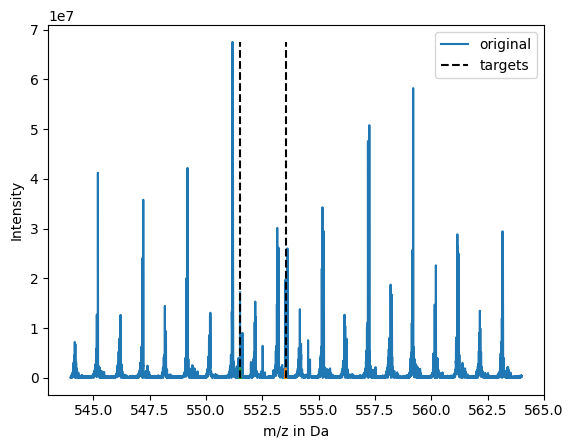

binning spectra: 100%|████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 291.48it/s]


In [18]:
from msi_workflow.res.compound_masses import mass_C37_2_Na_p, mass_C37_3_Na_p
spec = Spectra(path_d_folder=path_d_folder, initiate=False)
spec.load()
spec.set_targets(targets=[mass_C37_2_Na_p, mass_C37_3_Na_p], tolerances=3e-3, plts=True, reader=reader)

This branch of the pipeline is still missing the filtering. You can skip the untargeted chapter.

### Untargeted approach
Now let's proceed with the untargeted approach

In [29]:
spec = Spectra(path_d_folder=path_d_folder, initiate=False)
spec.load()

#### Peak finding
Now that the baseline is removed and the spectra are calibrated, we are ready to estimate the peaks. The most important parameter for setting the peaks is the prominence (0.1 by default, in terms of median intensity), a lower value will result in more peaks. This is a wrapper around scipy's `signal.find_peaks`

In [30]:
spec.set_peaks()

We can filter out peaks, for example by requiring a certain SNR threshold (we'd recommend using a threshold of at least 1, but furhter downstream there is another opportunity to filter out low SNR signals):

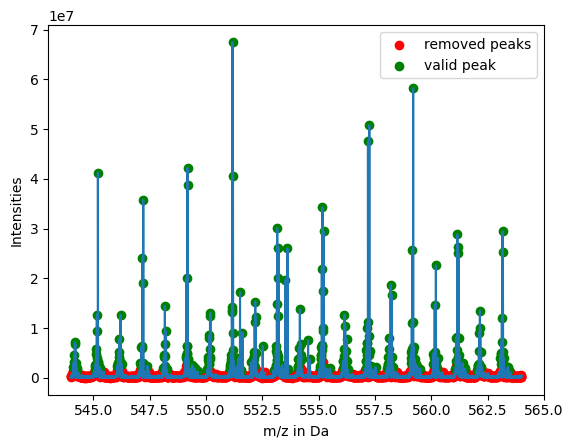

In [31]:
SNR_threshold = 1
spec.filter_peaks(SNR_threshold=SNR_threshold, plts=True)

or by detecting side-peaks (which are artifacts from the fourier transform), but usually they are quite low in there intensities and not a big concern

In [32]:
remove_sidepeaks = False
if remove_sidepeaks:
    spec.filter_peaks(remove_sidepeaks=remove_sidepeaks, plts=True)

#### Kernel estimation
Now that we found our peaks, we need to define which section of the spectrum belongs to each peak and where the centers of peaks are. The `Spectra` class implements a method that fits a Gaussian around each peak, making it robust against non-ideal peak shapes. It is also possible to estimate the kernels just from the height and width, which is more robust against very weird peak-shapes, but less accurate. Usually, you will encounter a few warnings for peaks where the peak parameters can not be estimated. Those can be co-eluting peaks or small artifacts and generally are nothing to worry about. If you want to make really sure, you can check out the peaks afterward

In [33]:
spec.set_kernels(sigma_max=5e-3)

sigma of kernel (7.5 mDa) with index 102 is bigger than max (5.0 mDa), halfing sigma.
encountered a value error while trying to find parameters for peak with index 102: 
 `x0` is infeasible. 
This can happen for double peaks.
sigma of kernel (5.1 mDa) with index 271 is bigger than max (5.0 mDa), halfing sigma.
encountered a value error while trying to find parameters for peak with index 271: 
 `x0` is infeasible. 
This can happen for double peaks.
sigma of kernel (7.6 mDa) with index 97 is bigger than max (5.0 mDa), halfing sigma.
encountered a value error while trying to find parameters for peak with index 97: 
 `x0` is infeasible. 
This can happen for double peaks.
sigma of kernel (5.2 mDa) with index 255 is bigger than max (5.0 mDa), halfing sigma.
encountered a value error while trying to find parameters for peak with index 255: 
 `x0` is infeasible. 
This can happen for double peaks.
sigma of kernel (8.3 mDa) with index 33 is bigger than max (5.0 mDa), halfing sigma.
encountered a

Let's check those sporious peaks out (we have to set the peaks again, because the sporious peaks will be removed within `set_kernels`)

sigma of kernel (7.5 mDa) with index 102 is bigger than max (5.0 mDa), halfing sigma.
encountered a value error while trying to find parameters for peak with index 102: 
 `x0` is infeasible. 
This can happen for double peaks.
sigma of kernel (5.1 mDa) with index 271 is bigger than max (5.0 mDa), halfing sigma.
encountered a value error while trying to find parameters for peak with index 271: 
 `x0` is infeasible. 
This can happen for double peaks.
sigma of kernel (7.6 mDa) with index 97 is bigger than max (5.0 mDa), halfing sigma.
encountered a value error while trying to find parameters for peak with index 97: 
 `x0` is infeasible. 
This can happen for double peaks.
sigma of kernel (5.2 mDa) with index 255 is bigger than max (5.0 mDa), halfing sigma.
encountered a value error while trying to find parameters for peak with index 255: 
 `x0` is infeasible. 
This can happen for double peaks.
sigma of kernel (8.3 mDa) with index 33 is bigger than max (5.0 mDa), halfing sigma.
encountered a

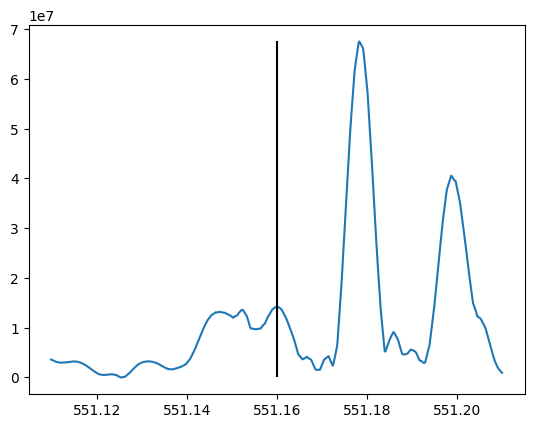

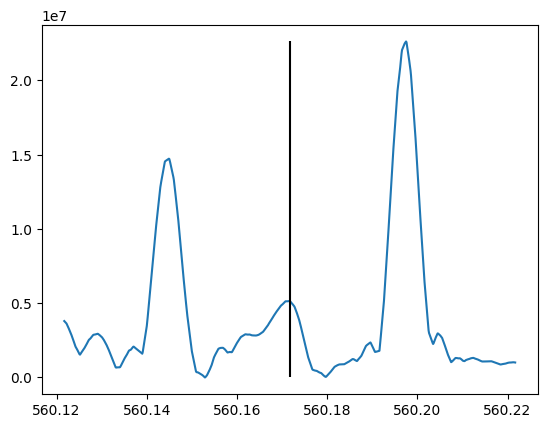

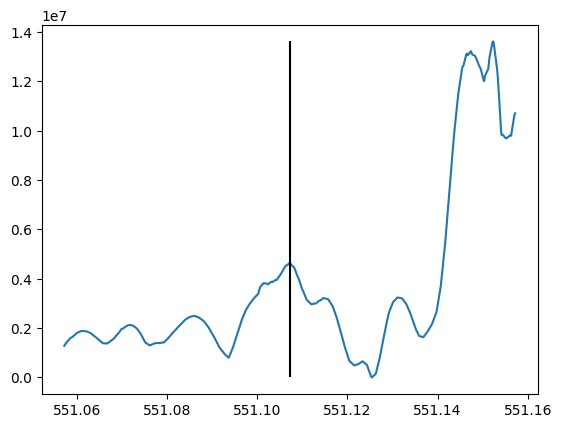

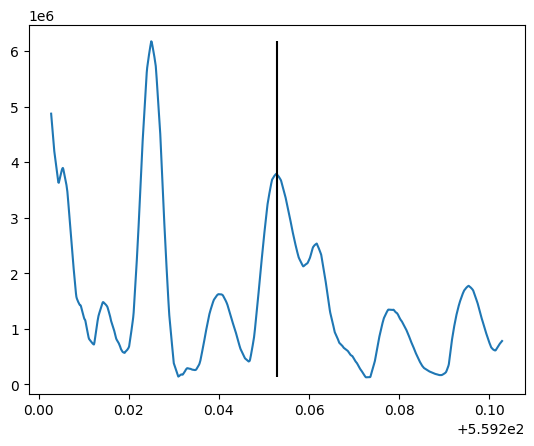

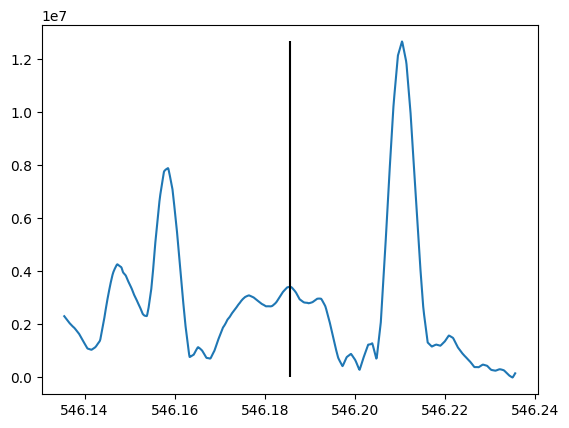

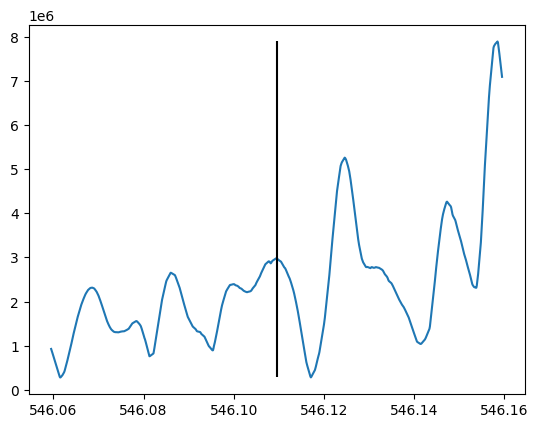

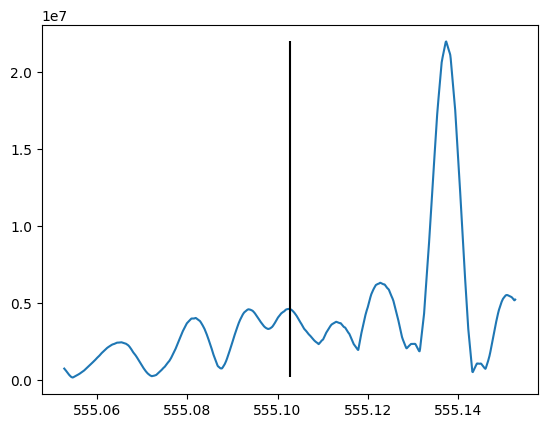

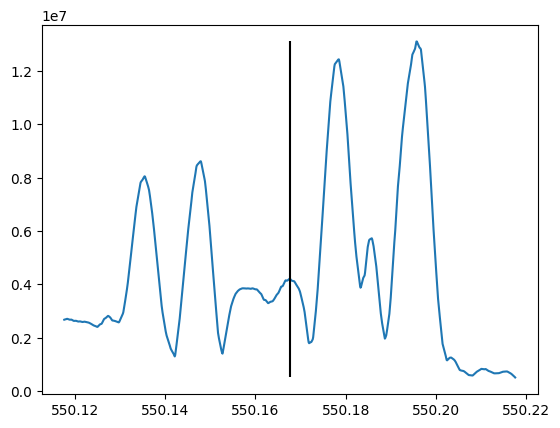

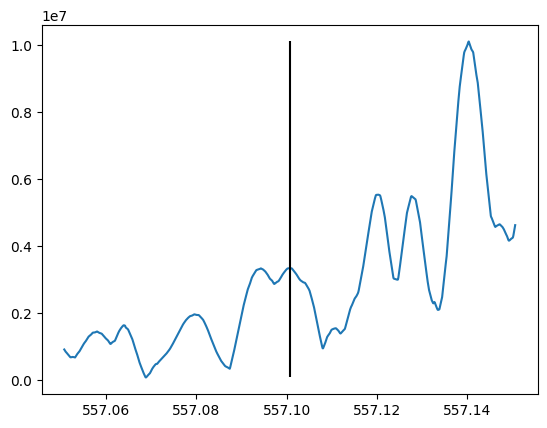

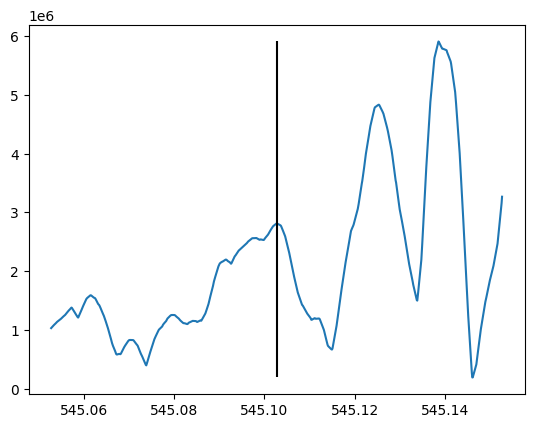

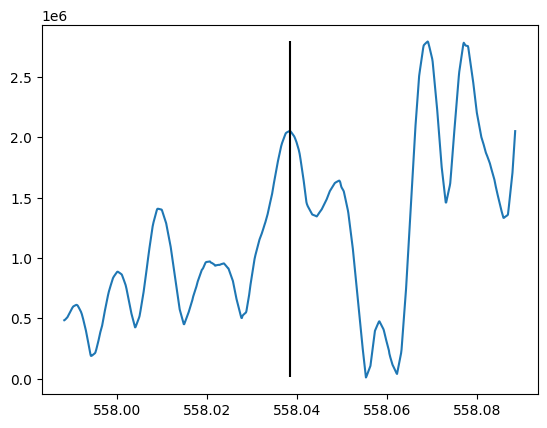

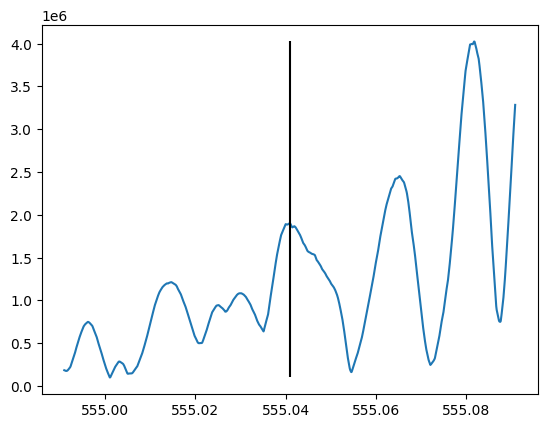

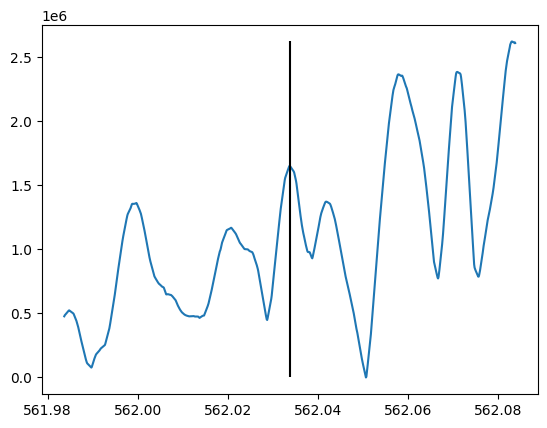

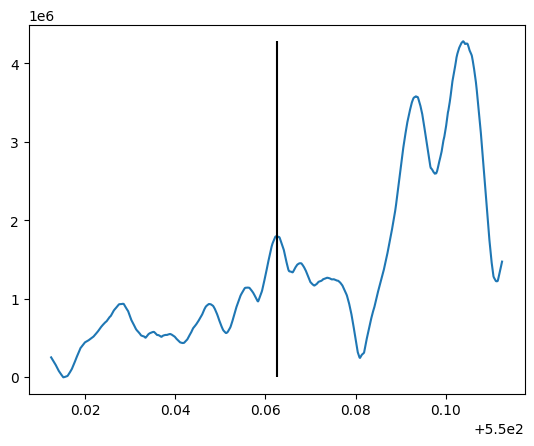

In [44]:
spec.set_peaks()
spec.filter_peaks(SNR_threshold=SNR_threshold)
spec.filter_peaks(remove_sidepeaks=remove_sidepeaks)
for idx in [102, 271, 97, 255, 33, 28, 175, 89, 207, 12, 226, 171, 293, 81]:
    center_mz = spec.mzs[spec._peaks[idx]]
    window_size = .1
    mask = (spec.mzs > center_mz - window_size / 2) & (spec.mzs < center_mz + window_size / 2)
    plt.plot(spec.mzs[mask], spec.intensities[mask])
    plt.vlines(center_mz, spec.intensities[mask].min(), spec.intensities[mask].max(), color='k')
    plt.show()

The peaks for which the estimation failed, are indeed not very sharp. This is partially due to the fairly low number of spectra in this toy example (noise is less likely to average out than for a full measurement). 

The next steps are the same as in the targeted approach

#### Binning the spectra
Using our kernels, we can now estimate the compound abundances within each spectrum

In [46]:
spec.set_peaks()
spec.filter_peaks(SNR_threshold=SNR_threshold)
spec.filter_peaks(remove_sidepeaks=remove_sidepeaks)
spec.set_kernels()
spec.bin_spectra(reader)

sigma of kernel (7.5 mDa) with index 102 is bigger than max (5.0 mDa), halfing sigma.
encountered a value error while trying to find parameters for peak with index 102: 
 `x0` is infeasible. 
This can happen for double peaks.
sigma of kernel (5.1 mDa) with index 271 is bigger than max (5.0 mDa), halfing sigma.
encountered a value error while trying to find parameters for peak with index 271: 
 `x0` is infeasible. 
This can happen for double peaks.
sigma of kernel (7.6 mDa) with index 97 is bigger than max (5.0 mDa), halfing sigma.
encountered a value error while trying to find parameters for peak with index 97: 
 `x0` is infeasible. 
This can happen for double peaks.
sigma of kernel (5.2 mDa) with index 255 is bigger than max (5.0 mDa), halfing sigma.
encountered a value error while trying to find parameters for peak with index 255: 
 `x0` is infeasible. 
This can happen for double peaks.
sigma of kernel (8.3 mDa) with index 33 is bigger than max (5.0 mDa), halfing sigma.
encountered a

and turn it into a feature table

In [48]:
df = spec.set_feature_table()
print(df)

        544.1222      544.1285        544.15      544.1813      544.1932  \
0   2.204708e+04  2.113741e+04  1.445800e+04  2.012194e+04  3.082086e+04   
1   1.140340e+04  1.553802e+04  2.437060e+04  7.797124e+03  6.216167e+03   
2   2.824265e+04  3.071752e+04  2.963774e+04  2.959464e+04  1.984523e+04   
3   4.710490e+04  6.695830e+04  4.096895e+04  6.647701e+04  1.140980e+04   
4   1.821878e+04  5.324917e+04  1.048647e+04  3.827332e+04  7.127972e+04   
..           ...           ...           ...           ...           ...   
67  2.670145e+04  1.297918e+04  1.226768e+04  2.287045e+04  2.270361e+04   
68  4.945966e+03  5.570553e+04  2.887264e+04  3.358988e+04  3.003335e+04   
69  1.745093e+06  1.551394e+06  4.138715e+06  6.976301e+06  1.049872e+06   
70  1.910851e+04  4.814935e+04  9.750204e+03  1.369384e+04  2.209779e+04   
71  3.120064e+04  4.182380e+04  2.389735e+04  3.585601e+04  3.277086e+04   

        544.2079       544.2422        544.263       544.2782        545.057  \
0   2.0

### Filtering intensities
This feature table may contain a lot of intensities that are below the noise level. It may be desirable to set those intensities to zero. Let's first look at how our ion image looks now and then do the filtering

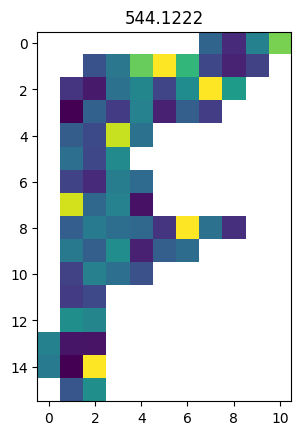

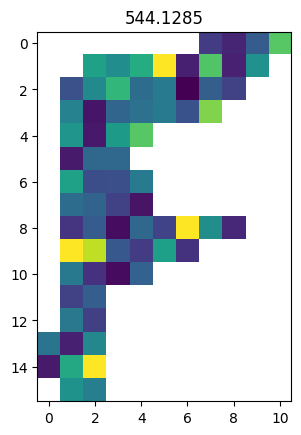

In [49]:
cols = spec.feature_table.columns[:2]
for col in cols:
    img = spec.feature_table.pivot(index='y', columns='x', values=col)
    clip = np.nanquantile(img, .95)
    img[img > clip] = clip
    plt.imshow(img)
    plt.title(col)
    plt.show()

Now let's do the filtering with an SNR of 2

In [50]:
_ = spec.filter_line_spectra(SNR_threshold=8)

and look at the ion images again

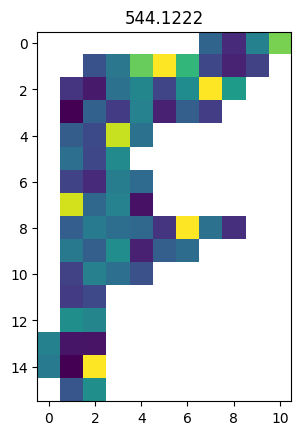

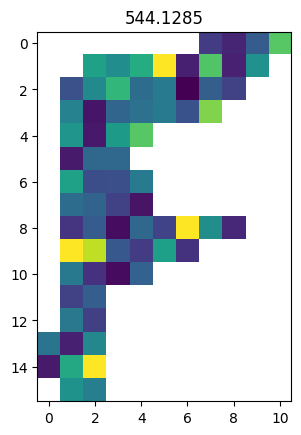

In [51]:
cols = spec.feature_table.columns[:2]
for col in cols:
    img = spec.feature_table.pivot(index='y', columns='x', values=col)
    clip = np.nanquantile(img, .95)
    img[img > clip] = clip
    plt.imshow(img)
    plt.title(col)
    plt.show()

Unfortunately, due to the low number of spectra the noise-level estimation is not working very well here.

### Shortcut
As in the previous section, we don't have to deal with all those steps. All we need to do is to specify the parameters and use the `ProjectMSI` class. To recapitulate, those parameters were
* `window_size`: the size of the minimum filter for subtracting the baseline (will be determined automatically if not provided)
* `calibrants_mz`: masses of calibrants to be used for calibrating spectra (will be taken from a list of known calibrants if not provided)
* `prominence`: minimum peak prominence for peaks to be considered relevant in the final feature table (default is 0.1, only untargeted approach)
* `targets`: list of target compounds (only targeted approach)
* `SNR_threshold`: required SNR value for intensities of compounds to be set to 0 (default is no filtering)

Adding spectra: 100%|█████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 364.13it/s]


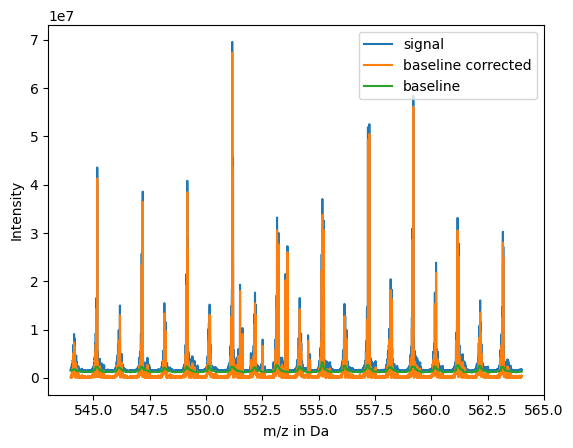

Found calibration file. This suggests that Lock Mass calibration has been performed already.
Finding calibration parameters: 100%|█████████████████████████████████████████████████| 72/72 [00:00<00:00, 328.35it/s]


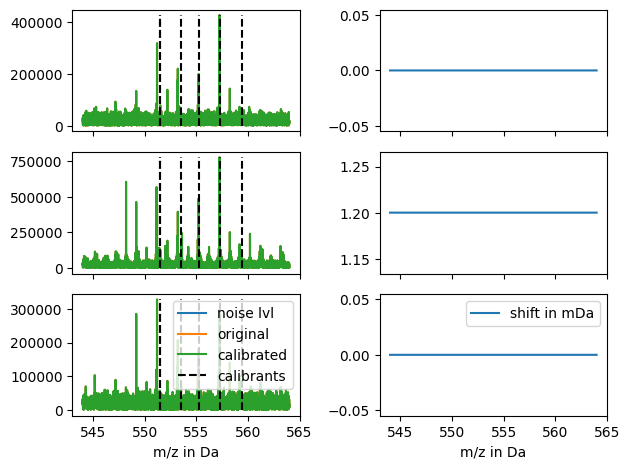

Adding spectra: 100%|█████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 264.91it/s]
sigma of kernel (7.5 mDa) with index 687 is bigger than max (5.0 mDa), halfing sigma.
encountered a value error while trying to find parameters for peak with index 687: 
 `x0` is infeasible. 
This can happen for double peaks.
sigma of kernel (5.1 mDa) with index 1534 is bigger than max (5.0 mDa), halfing sigma.
encountered a value error while trying to find parameters for peak with index 1534: 
 `x0` is infeasible. 
This can happen for double peaks.
sigma of kernel (7.6 mDa) with index 681 is bigger than max (5.0 mDa), halfing sigma.
encountered a value error while trying to find parameters for peak with index 681: 
 `x0` is infeasible. 
This can happen for double peaks.
sigma of kernel (5.2 mDa) with index 1452 is bigger than max (5.0 mDa), halfing sigma.
encountered a value error while trying to find parameters for peak with index 1452: 
 `x0` is infeasible. 
This c

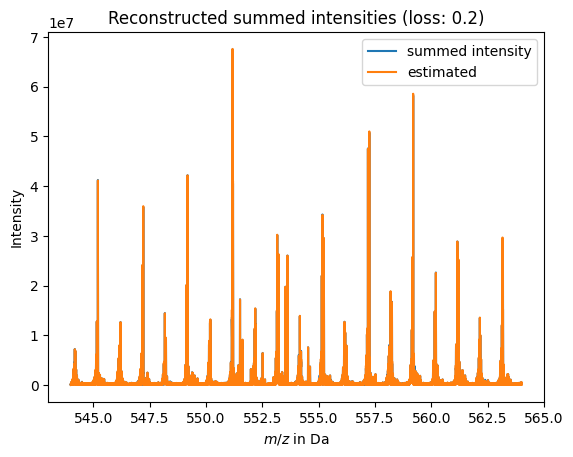

In [57]:
from msi_workflow import get_project

path_folder = r'C:\Users\Yannick Zander\Promotion\Test data'

project = get_project(is_MSI=True, path_folder=path_folder)
project.set_spectra(plts=True)

and visualization is more comfortable as well

Fetching intensities from Spectra: 100%|██████████████████████████████████████████████| 72/72 [00:00<00:00, 462.87it/s]
did not find x_ROI in Index([553.53188756536, 'R', 'x', 'y'], dtype='object'), attempting to find "x" and "y"


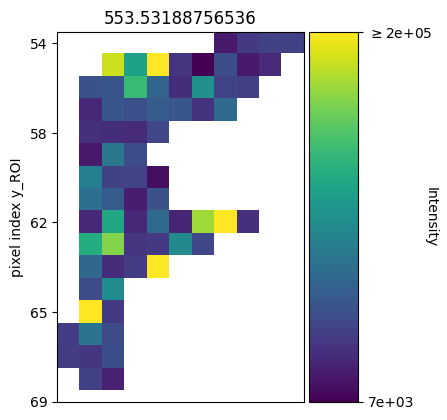

In [55]:
from msi_workflow.res.compound_masses import mC37_2

project.plot_comp(mC37_2, 'spectra', flip=True)

### Final remarks
Some functions take more parameters than discussed here. If you did not find what you were looking here, consider checking out the documentation. 

In general, we'd recommend using the *shortcut* way, but checking if results meet your expectations is still highly recommended (the `plts=True` parameter can be of help here)